# Fit multi-feature to spectra


*hylite* includes a powerful feature fitting technique that allows a spectra to be broken into multiple potentially overlapping Gaussian or Lorentzian features. The first half of this notebook shows this applied to a spectral library, so that the results can be easily plotted and checked. Then we apply multi-feature minimum wavelength mapping to a hyperspectral image to distinguish different minerals. 


In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

import hylite
from hylite import io
from hylite import HyFeature
from hylite.correct import get_hull_corrected
from hylite.analyse import minimum_wavelength, colourise_mwl, closestFeature, sortMultiMWL, getMixedFeature

### Load spectral library

In [3]:
lib = io.loadLibraryCSV(r'../../test_data/library.csv')

Apply hull correction to region of interest

In [ ]:
lib_hc = get_hull_corrected(lib, band_range=(2155.0,2340.0))

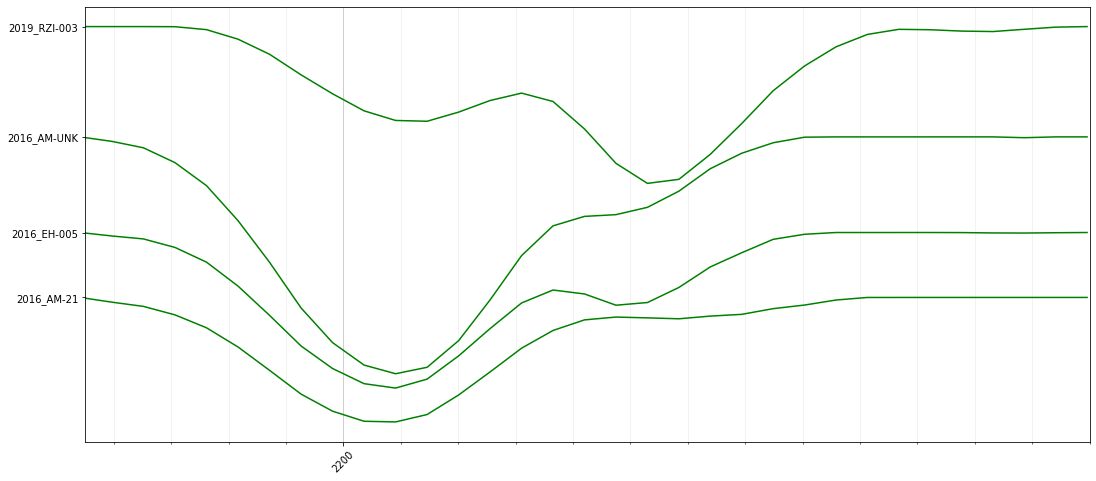

In [18]:
fig,ax = lib_hc.quick_plot(samples=['2016_AM-21','2016_EH-005','2016_AM-UNK','2019_RZI-003'],labels=[])
ax.set_xlim(2155.0,2330.0)
fig.show()

### Extract spectra

Extract some of the spectra in the spectral library as numpy arrays

In [19]:
refl = lib_hc.get_sample_spectra('2019_RZI-003')
wav = lib_hc.get_wavelengths()

### Fit single features

Can you see why this is a bad idea?

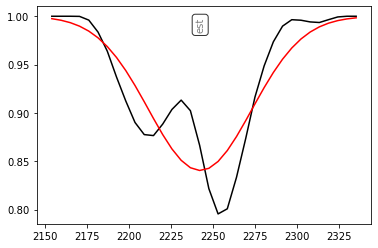

In [20]:
fit = HyFeature.fit(wav, refl, method='gauss', n=1)
fig,ax = fit.quick_plot()

### Fit multiple features 

Problem solved?

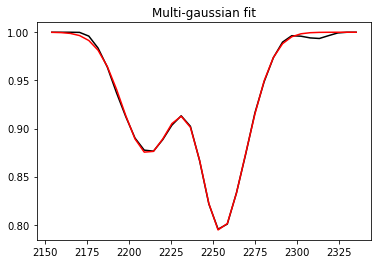

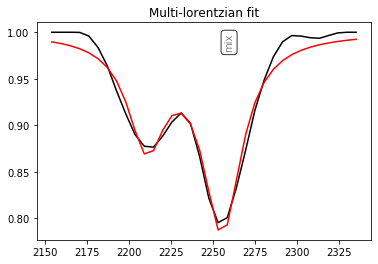

In [21]:
fit = HyFeature.fit(wav, refl, method='gauss',n=3)
fig,ax = fit.quick_plot( method='gauss', label=None )
ax.set_title("Multi-gaussian fit")
fig.show()

fit = HyFeature.fit(wav, refl, method='lorentz',n=3)
fig,ax = fit.quick_plot( method='lorentz' )
ax.set_title("Multi-lorentzian fit")
fig.show()

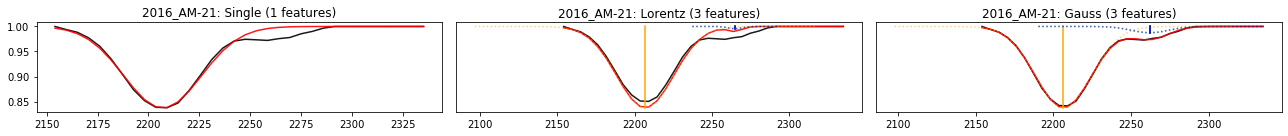

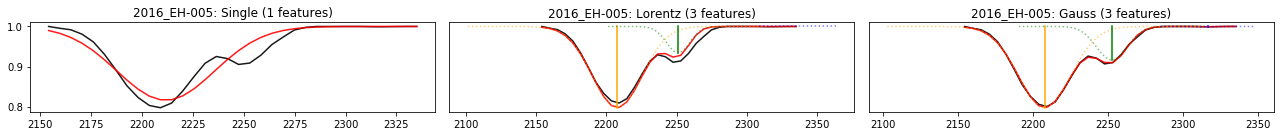

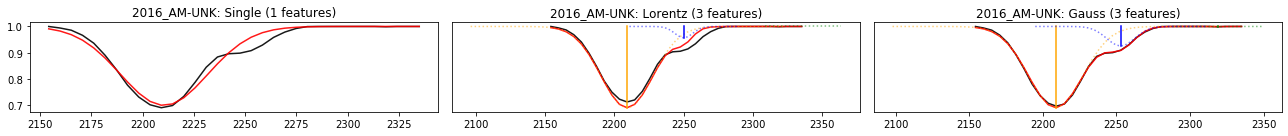

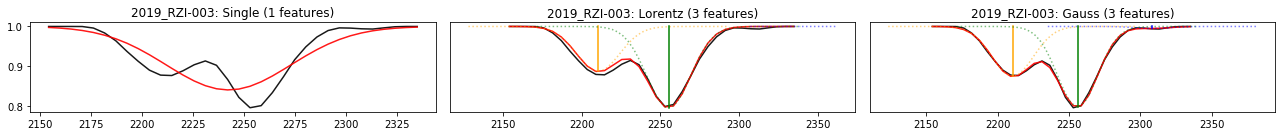

In [22]:
for n in ['2016_AM-21','2016_EH-005','2016_AM-UNK','2019_RZI-003']: # lib_hc.get_sample_names(): #
    
    refl = lib_hc.get_sample_spectra(n)
    wav = lib_hc.get_wavelengths()
    
    ftol = 1e-2
    fit_single = HyFeature.fit(wav,refl,method='gauss',n=1,ftol=ftol)
    fit_gauss = HyFeature.fit(wav, refl, method='gauss',n=3,ftol=ftol)
    fit_lorentz = HyFeature.fit(wav, refl, method='lorentz',n=3,ftol=ftol)
    
    fig,ax = plt.subplots(1,3,figsize=(18,2))
    for a,t,f in zip(ax,['Single','Lorentz','Gauss'],[fit_single,fit_lorentz,fit_gauss]):
        f.quick_plot(ax=a, alpha=0.9, label=None)
        if f.components is None:
            a.set_title("%s: %s (%d features)" % (n, t,1))
        else:
            a.set_title("%s: %s (%d features)" % (n, t,len(f.components)))
            colors=['orange','g','b','gray']
            for i,c in enumerate(f.components):
                c.color = colors[i]
                c.data = None
                c.quick_plot( ax=a, alpha=0.5, linestyle='dotted', label=None )
                a.plot( [c.pos, c.pos], [1.0, 1.0-c.depth], color=colors[i] )
                
        #a.set_ylim(0.8,1.0)
        if not 'Single' in t:
            a.set_yticks([])
    fig.tight_layout()
    fig.show()

### Use multi-feature technique for mwl mapping

Fit multiple gaussian features to the SWIR region of an hyperspectral image of a rock sample.

In [ ]:
# load image
image = io.loadWithGDAL( '../demo_data/image.hdr')

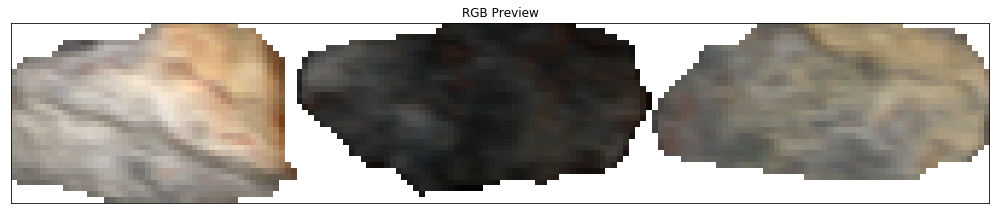

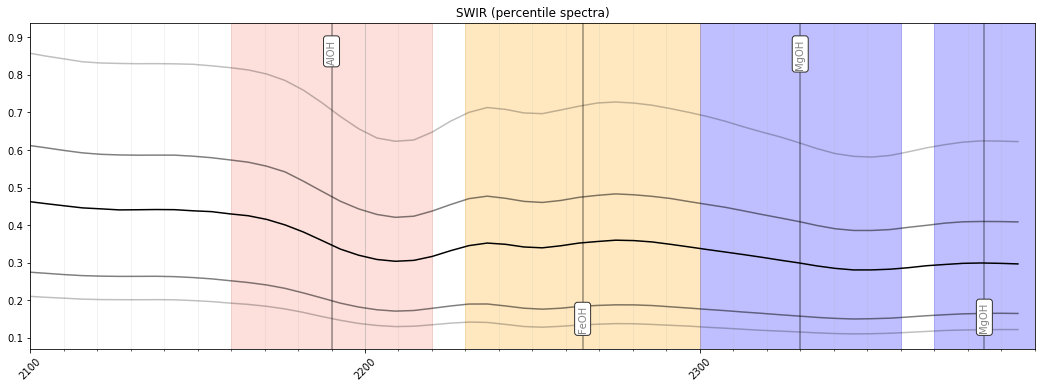

In [41]:
# plot RGB preview
fig,ax = image.quick_plot( hylite.RGB )
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("RGB Preview")
fig.show()

# plot spectral summary
fig,ax = image.plot_spectra( band_range=(2000.,2400.))
ax.set_xlim(2100,2400)
ax.set_title("SWIR (percentile spectra)")
fig.show()

Calculate minimum wavelength map:

In [46]:
minw, maxw = 2140., 2400. # range to do mwl mapping over
detrend = 'hull' # detrending method
n = 3 # number of features to fit
ftype = 'gauss' # 'gaussian' or 'lorentzian' feature
threads = 1 # number of threads to distribute computation across (for large datasets)

In [ ]:
mwl = minimum_wavelength( image, minw, maxw, method=ftype, trend=detrend, n=n, threads=threads, vb=True)

### Visualise minimum wavelength maps

Sort features by depth and map to RGB

In [48]:
mwl = sortMultiMWL( mwl, 'depth' )
rgb = [colourise_mwl(m,strength=True,hue_map='swir',depth_map=(0,0.15)) for m in mwl]

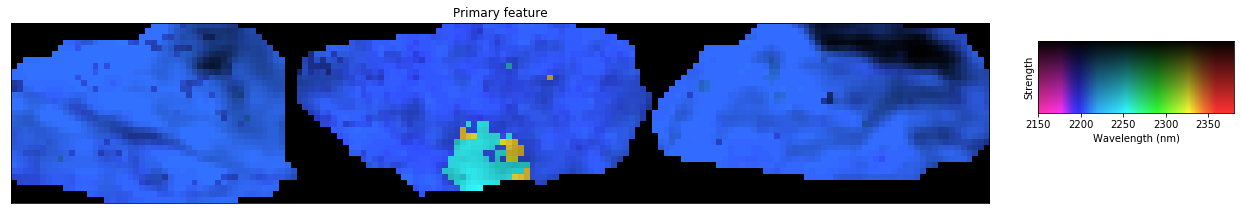

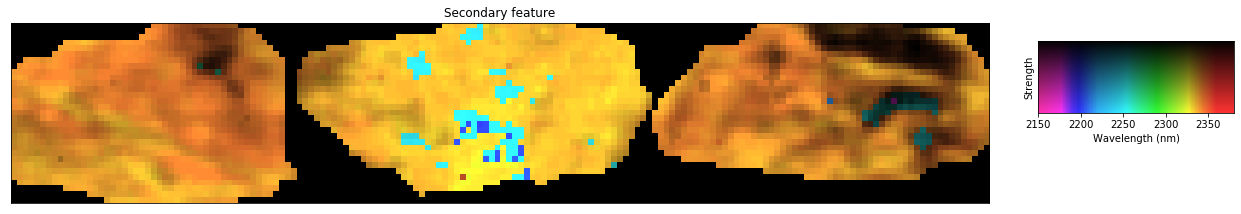

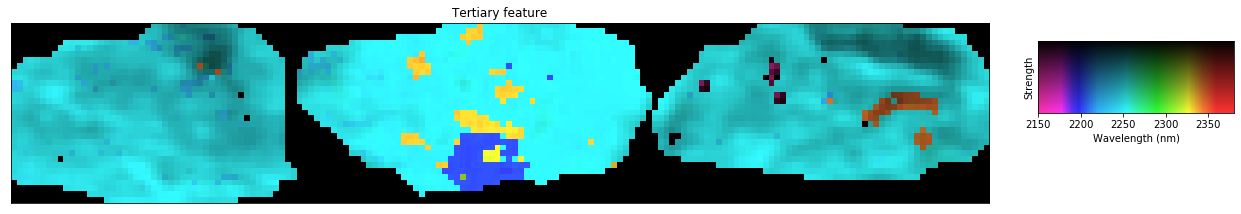

In [56]:
for _rgb, title in zip(rgb,["Primary", "Secondary", "Tertiary"]):
    fig, ax = _rgb[0].quick_plot((0,1,2), vmin=0, vmax=1)
    ax.set_xticks( [] )
    ax.set_yticks( [] )
    ax.set_title("%s feature" % title)
    
    # plot legend
    _rgb[1].plot(ax, pos=(1.05,0.5), s=(0.2,0.4))
    
    fig.show()

### Extract and analyse specific features

Extract the AlOH feature (where it exists) and map its position:

In [57]:
F2200 = closestFeature( mwl, 2200., valid_range=(2100.,2230.), depth_cutoff=0.05 )

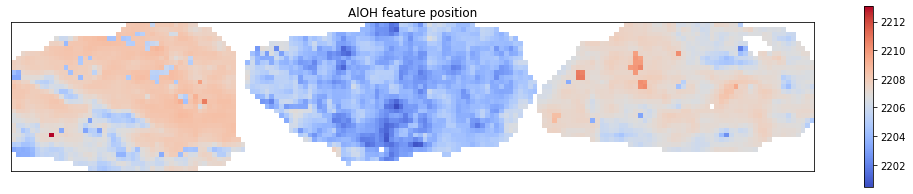

In [68]:
fig,ax = F2200.quick_plot( 0, cmap='coolwarm' ) # plot feature position
fig.colorbar( ax.cbar )
ax.set_xticks( [] )
ax.set_yticks( [] )
ax.set_title("AlOH feature position")
fig.show()

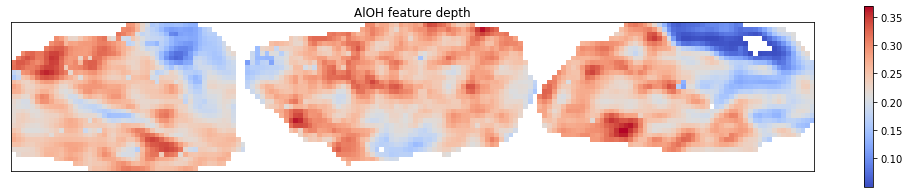

In [64]:
fig,ax = F2200.quick_plot( 2, cmap='coolwarm' ) # plot feature depth
fig.colorbar( ax.cbar )
ax.set_xticks( [] )
ax.set_yticks( [] )
ax.set_title("AlOH feature depth")
fig.show()